In [120]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

train = pd.read_csv("output/sorted_train0310.csv")
test = pd.read_csv("output/sorted_test0310.csv")
val = pd.read_csv("output/sorted_val0310.csv")

In [ ]:
train = train[train['LoanStatus'] != 'MISSING']
test = test[test['LoanStatus'] != 'MISSING']
val = val[val['LoanStatus'] != 'MISSING']
print train['LoanStatus'].unique()
print test['LoanStatus'].unique()
print val['LoanStatus'].unique()

In [112]:
# Define function to calculate the relative time to a default
from datetime import datetime

def calculate_days_to_default(approval, chargeoff, terms):
    # No default occurred, return TermInMonths in days
    if pd.isnull(chargeoff):
        return terms / 12 * 365
    
    d1 = datetime.strptime(approval.split()[0], "%Y-%m-%d")
    d2 = datetime.strptime(chargeoff.split()[0], "%Y-%m-%d")
    return (d2 - d1).days

def add_relative_time_col(df):
    DaysToDefault = []
    for index, row in df.iterrows():
        approval = row["ApprovalDate"]
        chargeoff = row["ChargeOffDate"]
        terms = row['TermInMonths']
        DaysToDefault.append(calculate_days_to_default(approval, chargeoff, terms))

    df['DaysToDefault'] = pd.Series(DaysToDefault).values

    # Remove ApprovalDate, ChargeOffDate -- we no longer need these columns
#     df = df.drop(columns=["ApprovalDate", "ChargeOffDate"])

    # Convert True/False to 0/1s for Default? column
    df['Default?'] = df['LoanStatus']=='CHGOFF'
    df['Default?'] = df['Default?'].astype(int)
    return df

In [113]:
train = add_relative_time_col(train)
train.columns.tolist()

In [115]:
# filtering for the columns you don't want to include for your model
c = train.columns.tolist()
c.remove('LoanStatus')
c.remove('ChargeOffDate')
c.remove('GrossChargeOffAmount')
c.remove('BorrZip')
c.remove('CDC_Zip')
c.remove('BorrCity')

c.remove('BorrState')
c.remove('CDC_State')
c.remove('ThirdPartyLender_State')
c.remove('ProjectState')

c.remove('CDC_City')
c.remove('ProjectCounty')
c.remove('ThirdPartyLender_City')
c.remove('ApprovalDate')
# c.remove('DaysToDefault')
# c.remove('Default?')
print c

['ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Log_GrossApproval_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics', 'DaysToDefault', 'Default?']


In [ ]:
x_train = train[c]
print x_train.columns.tolist()
x_train = pd.get_dummies(x_train)
print x_train.shape

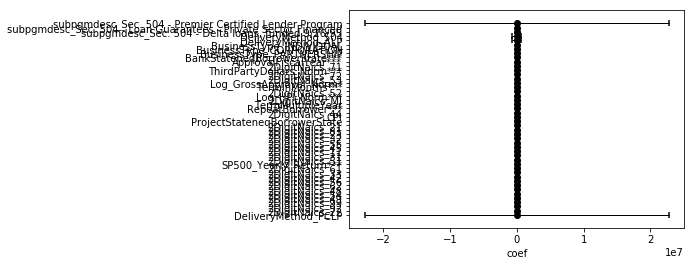

In [121]:
# hazard rate model on all loan samples
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(x_train, duration_col='DaysToDefault', event_col='Default?')

cph.plot()

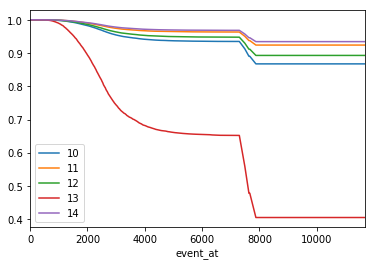

In [131]:
cph.predict_survival_function(x_train[10:15].drop(['DaysToDefault','Default?'], axis = 1)).plot()

In [139]:
print x_train['DaysToDefault'][10:15]

10    7300
11    7300
12    7300
13    7300
14    3650
Name: DaysToDefault, dtype: int64


In [122]:
cph.print_summary()

n=43845, number of events=5336

                                                         coef  exp(coef)      se(coef)       z      p     lower 0.95    upper 0.95     
ApprovalFiscalYear                                     0.2286     1.2569        0.0120 19.0820 0.0000         0.2051        0.2521  ***
TermInMonths                                          -0.0028     0.9972        0.0005 -5.3293 0.0000        -0.0038       -0.0018  ***
SP500_Yearly_Return                                   -0.6363     0.5293        0.1071 -5.9395 0.0000        -0.8462       -0.4263  ***
CPI                                                   -0.2779     0.7574        0.4902 -0.5668 0.5708        -1.2386        0.6829     
Log_GrossApproval_Norm                                 0.0309     1.0313        0.0153  2.0174 0.0437         0.0009        0.0608    *
Log_HPI_Norm                                          -0.1281     0.8797        0.0198 -6.4588 0.0000        -0.1670       -0.0892  ***
ThirdPartyDollar

In [4]:
# to get consistent feature dimensions for both train and test dataset
def add_missing_dummy_columns(d1, d2):
    missing_cols = set(d1.columns) - set(d2.columns)
    for c in missing_cols:
        d2[c] = 0
    return d2

print 'before fix columns: '
print x_train.shape
print x_test.shape

def fix_columns(x_train, x_test):  

    x_test = add_missing_dummy_columns(x_train, x_test)

    extra_cols = set(x_test.columns) - set(x_train.columns)
    x_test = x_test[x_train.columns]
    return x_test

x_test = fix_columns(x_train, x_test)
print 'after fix columns: '
print x_train.shape
print x_test.shape

before fix columns: 
(43845, 5862)
(5481, 2188)
after fix columns: 
(43845, 5862)
(5481, 5862)


In [133]:
# hazard model only on data that is death event - only on the ones that are charged off
death = train[train['LoanStatus'] == 'CHGOFF']
death = death.reset_index(drop=True)
death['Duration'] = pd.to_datetime(death['ChargeOffDate']) - pd.to_datetime(death['ApprovalDate'])
death['Observed'] = 1
death = death[c]
death.head()

,ApprovalFiscalYear,DeliveryMethod,subpgmdesc,TermInMonths,BusinessType,SP500_Yearly_Return,CPI,Log_GrossApproval_Norm,Log_HPI_Norm,ThirdPartyDollars_Norm,TermMultipleYear,RepeatBorrower,BankStateneqBorrowerState,ProjectStateneqBorrowerState,2DigitNaics,DaysToDefault,Default?
0,2004,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.120274,0.969,0.335743,0.266927,0.480989,True,0,False,False,72,1537,1
1,2004,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.120274,0.969,1.421916,0.266927,-0.377884,True,0,False,False,71,2977,1
2,2005,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.065440,1.040,-1.477124,0.454916,-0.196954,True,0,False,False,54,1848,1
3,2006,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.155040,1.081,-0.180838,1.497527,0.170356,True,0,True,False,33,2711,1
4,1999,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.305258,0.887,0.286921,-0.555141,-0.377884,True,0,False,False,MI,2909,1


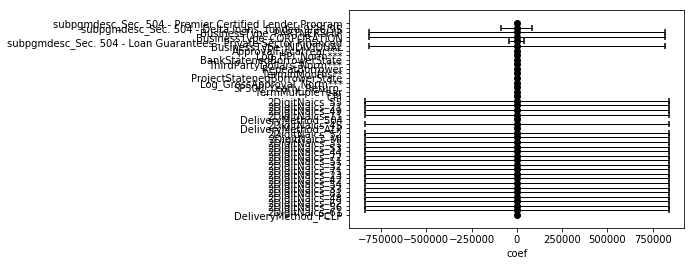

In [135]:
x_train_death = pd.get_dummies(death)

# hazard rate model on only charged off loan samples
cph = CoxPHFitter()
cph.fit(x_train_death, duration_col='DaysToDefault', event_col='Default?')

cph.plot()

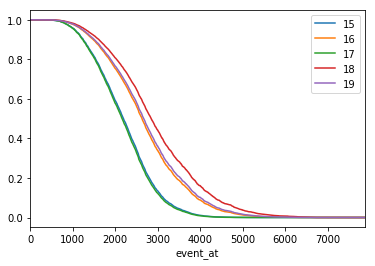

In [146]:
cph.predict_survival_function(x_train_death[15:20].drop(['DaysToDefault','Default?'], axis = 1)).plot()

In [144]:
x_train_death['TermInMonths'][15:20]

15    240
16    120
17    240
18    240
19    240
Name: TermInMonths, dtype: int64